In [34]:
# ========================================================================================
# JAX 1D-FDM + Newton inverse fitting (hout, hwi, hwo)
# - 목적: 140/280/420W 각 전력 케이스별로 (hout, hwi, hwo) '상수' 3개를 JAX로 피팅
# - 특징:
#   * MLP 사용 안함 (식별성/안정성 우선)
#   * Newton warm-start: 직전 step 해를 다음 step 초기값으로 사용 (stop_gradient로 경로 차단)
#   * 케이스별 파라미터 테이블(theta_raw[case_id, :]) 최적화
# ========================================================================================

In [35]:
# -------------------------------------------
# 0) 라이브러리 로드
# -------------------------------------------
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import lax
import optax

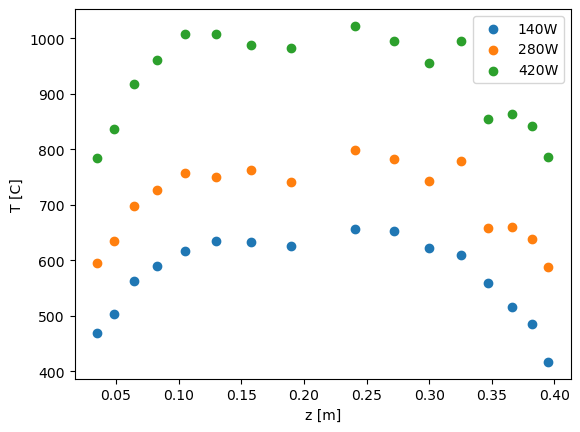

In [36]:
# ------------------------------------------------------------------------------------
# 1) 데이터 로드
# ------------------------------------------------------------------------------------
tc_pos = jnp.array(json.load(open('tc_pos.json'))) # Thermocouple position[m]
T_140 = jnp.array(json.load(open('Temp_profile_140W.json'))) # Temperature profile @ 140W [C]
T_280 = jnp.array(json.load(open('Temp_profile_280W.json'))) # Temperature profile @ 280W [C]
T_420 = jnp.array(json.load(open('Temp_profile_420W.json'))) # Temperature profile @ 420W [C]

powers = jnp.array([140.0, 280.0, 420.0]) # Applied power [W]
T_meas_cases = jnp.array([T_140, T_280, T_420]) # Measured temperature profile [C] (3, n_TC)
num_cases, n_TC = T_meas_cases.shape

plt.figure()
plt.scatter(np.array(tc_pos), np.array(T_140), label='140W')
plt.scatter(np.array(tc_pos), np.array(T_280), label='280W')
plt.scatter(np.array(tc_pos), np.array(T_420), label='420W')
plt.legend(); plt.xlabel('z [m]'); plt.ylabel('T [C]'); plt.show()

In [37]:
# ------------------------------------------------------------------------------------
# 2) Geometry / Grid
# ------------------------------------------------------------------------------------
L = 430e-3  # Reactor length [m]
ID = 5.03e-3  # Inner diameter [m]
OD = 6.33e-3  # Outer diameter [m]

Ai = jnp.pi * ID**2 / 4  # Inner cross-sectional area [m2]
Ao = jnp.pi * OD**2 / 4  # Outer cross-sectional area [m2]
Aw = Ao - Ai  # Wall cross-sectional area [m2]
pri = jnp.pi * ID  # Inner perimeter [m]
pro = jnp.pi * OD  # Outer perimeter [m]

dz = 0.001  # Grid size [m]
n_nodes = int(L/dz) + 1  # Number of nodes
z = jnp.linspace(0, L, n_nodes)  # Node positions [m]

Awg = pri * dz # inner surface area per grid [m2]
Aout = pro * dz # outer surface area per grid [m2]

tc_idx = jnp.array([
    jnp.argmin(jnp.abs(z - zp)) for zp in tc_pos
])

In [38]:
# ------------------------------------------------------------------------------------
# 3) Material properties (He, KanthalD)
# ------------------------------------------------------------------------------------
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'

df_he = pd.read_csv(path_he)
df_kt = pd.read_csv(path_kt)
df_kt_k = df_kt[df_kt['k [W/m*K]'].notna()]
df_kt_cp = df_kt[df_kt['Cp [kJ/kg*K]'].notna()]

Mw_he = 4.0026 # He molar weight [g/mol]

## Jax-friendly 1D interpolation
def interp1d(xq, x, y):
    xq = jnp.asarray(xq)
    x  = jnp.asarray(x)
    y  = jnp.asarray(y)
    return jnp.interp(xq, x, y)

## Properties of He
def rho_he(T): # He mass density [kg/m3]
    return interp1d(T, df_he['T [C]'], df_he['rho [kg/m3]'])

def cp_he(T): # He specific heat [J/mol*K]
    return interp1d(T, df_he['T [C]'], df_he['Cp [J/mol*K]'])

def k_he(T): # He thermal conductivity [W/m/K]
    return interp1d(T, df_he['T [C]'], df_he['Tc [W/m*K]'])

## Properties of kanthalD
def rho_kt(T): # kanthalD mass density [kg/m3]
    return interp1d(T, df_kt['T [C]'], df_kt['rho [kg/m3]'])

def cp_kt(T): # kanthalD specific heat [J/kg*K]
    return interp1d(T, df_kt_cp['T [C]'], df_kt_cp['Cp [kJ/kg*K]'])*1000

def k_kt(T): # kanthalD thermal conductivity [W/m*K]
    return interp1d(T, df_kt_k['T [C]'], df_kt_k['k [W/m*K]'])

## heat transfer coefficient of inner fluid
def h_wg(Tg):
    Nu = 4.36
    return Nu * k_he(Tg) / ID

In [39]:
# ------------------------------------------------------------------------------------
# 4) Feed conditions / constant
# ------------------------------------------------------------------------------------
P = 101325.0 # pressure [Pa]
Tamb = 25.0 # ambient temperature [C]

Fv_std = 50.0 # volumetric feed flow rate at standard condition [mL/min]
Fw = Fv_std * 1e-6 / 60 * rho_he(0) # feed mass flow rate [kg/s]
F = Fw / Mw_he * 1000.0 # feed molar flow rate [mol/s]

In [40]:
# ------------------------------------------------------------------------------------
# 5) Residual function
#   - coeffs=(hout, hwi, hwo) + Pw
# ------------------------------------------------------------------------------------
def residual(U, coeffs, Pw):
    hout = coeffs
    hwi = 1000
    hwo = 1000

    Tw = U[:n_nodes]
    Tg = U[n_nodes:]

    kw = k_kt(Tw)
    cpg = cp_he(Tg)
    hwg = h_wg(Tg)


    ## joule heating
    Qelec = Pw * dz / L # heat generation per unit length [W]

    ## residual variables initialization
    rw = jnp.zeros((n_nodes,))
    rg = jnp.zeros((n_nodes,))

    ## Wall 
    ### Robin BC for Tw: heat loss on the front and back surfaces
    rw = rw.at[0].set(hwi * Aw * (Tw[0] - Tamb) + kw[0] * Aw * (Tw[0] - Tw[1]) / dz)
    rw = rw.at[-1].set(hwo * Aw * (Tw[-1] - Tamb) + kw[-1] * Aw * (Tw[-1] - Tw[-2]) / dz)

    ### interior conduction
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz

    ### wall-gas exchange + outer loss
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout * Aout * (Tw[1:-1] - Tamb)

    ### wall energy balance
    rw = rw.at[1:-1].set(Qcond + (Qelec/dz) - (Qwg/dz) - (Qout/dz))
    
    ## Gas
    ### Assume no temperature difference between the gas and the wall at the front and back
    rg = rg.at[0].set(Tg[0] - Tw[0])
    rg = rg.at[-1].set(Tg[-1] - Tw[-1])

    ### gas energy balance
    gflux = F * cpg[1:-1] * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set((Qwg/dz) - gflux)

    return jnp.concatenate([rw, rg])

In [41]:
# ------------------------------------------------------------------------------------
# 6) Newton solver (JAX, scan)
# ------------------------------------------------------------------------------------
def newton_step(residual_fn, damping = 1.0):
    # residual_fn: U -> r
    def step(U, _):
        F = residual_fn(U)
        # J = dr/dU
        J = jax.jacfwd(residual_fn)(U)
        # solve J dU = -r
        dU = jnp.linalg.solve(J, -F)
        U_new = U + damping * dU

        res_norm = jnp.linalg.norm(F)
        step_norm = jnp.linalg.norm(dU)

        return U_new, (res_norm, step_norm)
    return step

def newton_solve(residual_fn, iters=20, damping=1.0):
    step = newton_step(residual_fn, damping = damping)
    def solve(U0):
        U_final, (res_hist, step_hist) = lax.scan(step, U0, xs=None, length=iters)
        return U_final, res_hist, step_hist
    return solve

In [42]:
# ------------------------------------------------------------------------------------
# 7) Case solver + prediction
# ------------------------------------------------------------------------------------
def solve_case(coeffs, Pw, U0, iters=20, damping=1.0):
    res_fn = lambda U: residual(U, coeffs, Pw)
    newton = newton_solve(res_fn, iters=iters, damping=damping)
    U_star, res_hist, step_hist = newton(U0)
    return U_star, res_hist, step_hist

def predict_TC(U):
    Tw = U[:n_nodes]
    return Tw[tc_idx]

In [43]:
# ------------------------------------------------------------------------------------
# 8) Fitting setup
#   - theta_raw shape: (num_case, 3), softplus로 양수화
#   - warm-start: U0_case를 step마다 업데이트 (stop_gradient)
# ------------------------------------------------------------------------------------
def theta_phys(theta_raw):
    eps = 1e-6
    h = jax.nn.softplus(theta_raw) + eps
    h = jnp.clip(h, jnp.array([1.0]), jnp.array([100]))
    return h

def softplus_inv(h):
    return jnp.log(jnp.exp(h) - 1.0)

h_init = jnp.array([
    [30.],
    [30.],
    [30.]
])

# initial state
Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])

U0_cases = jnp.stack([U0, U0, U0])  # (num_cases, 2*n_nodes)

# initialize theta_raw (learning parameters)
theta_raw = softplus_inv(h_init)   # (3,3)

def case_loss(coeffs, Pw, U0, T_meas):
    U_star, res_hist, step_hist = solve_case(coeffs, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    # Return convergence diagnostics along with loss
    final_res = res_hist[-1]
    final_step = step_hist[-1]
    return loss, U_star, final_res, final_step

def total_loss(theta_raw, U0_cases, T_meas_cases, powers):
    theta = theta_phys(theta_raw)

    def one_case(theta_k, U0_k, T_k, Pw_k):
        loss_k, _, _, _ = case_loss(theta_k, Pw_k, U0_k, T_k)
        return loss_k

    losses = jax.vmap(one_case)(theta, U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update(theta_raw, U0_cases, T_meas_cases, powers):
    theta = theta_phys(theta_raw)

    def one_case(theta_k, U0_k, T_k, Pw_k):
        _, U_star, _, _ = case_loss(theta_k, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)

    return jax.vmap(one_case)(theta, U0_cases, T_meas_cases, powers)

def get_newton_convergence(theta_raw, U0_cases, T_meas_cases, powers):
    """Get Newton convergence diagnostics for all cases"""
    theta = theta_phys(theta_raw)

    def one_case(theta_k, U0_k, T_k, Pw_k):
        _, _, final_res, final_step = case_loss(theta_k, Pw_k, U0_k, T_k)
        return final_res, final_step

    res_norms, step_norms = jax.vmap(one_case)(theta, U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

In [44]:
# ------------------------------------------------------------------------------------
# 9) Training Loop (optax) with Newton Convergence Diagnostics
# ------------------------------------------------------------------------------------
opt = optax.adam(learning_rate = 1e-3)
opt_state = opt.init(theta_raw)

loss_and_grad = jax.value_and_grad(total_loss)

print("=" * 80)
print("TRAINING START: Newton Convergence Diagnostics Enabled")
print("=" * 80)

for step in range(30):
    loss, grads = loss_and_grad(theta_raw, U0_cases, T_meas_cases, powers)
    updates, opt_state = opt.update(grads, opt_state)
    theta_raw = optax.apply_updates(theta_raw, updates)

    # Get Newton convergence info
    res_norms, step_norms = get_newton_convergence(theta_raw, U0_cases, T_meas_cases, powers)
    
    # warm-start Newton initial guesses
    U0_cases = warm_start_update(theta_raw, U0_cases, T_meas_cases, powers)

    if step % 1 == 0:
        theta = theta_phys(theta_raw)
        print(f'\n{"=" * 80}')
        print(f'EPOCH {step:04d} | Total Loss = {float(loss):.6e}')
        print(f'{"=" * 80}')
        
        # Parameter values and gradients
        for k, Pw_k in enumerate([140., 280., 420.]):
            #hout_k, hwi_k, hwo_k = map(float, theta[k])
            #grad_hout, grad_hwi, grad_hwo = map(float, grads[k])
            hout_k = map(float, theta[k])
            grad_hout = map(float, grads[k])
            
            print(f'\n  Case {k+1} ({Pw_k}W):')
            print(f'    Parameters: hout={hout_k:.3f}')
            print(f'    Gradients:  ∇hout={grad_hout:.3e}')
            print(f'    Newton:     ||F||={float(res_norms[k]):.3e}, ||dU||={float(step_norms[k]):.3e}')
            
            # Check if parameters are stuck at bounds
            at_lower = [hout_k <= 1.01]
            at_upper = [hout_k >= 99.9]
            if any(at_lower) or any(at_upper):
                bound_info = []
                if at_lower[0] or at_upper[0]: bound_info.append("hout")
                if at_lower[1] or at_upper[1]: bound_info.append("hwi")
                if at_lower[2] or at_upper[2]: bound_info.append("hwo")
                print(f'    ⚠️  WARNING: Parameters at boundary → {", ".join(bound_info)}')
        
        print(f'{"=" * 80}')

TRAINING START: Newton Convergence Diagnostics Enabled

EPOCH 0000 | Total Loss = 6.370134e+05

  Case 1 (140.0W):


TypeError: unsupported format string passed to map.__format__

In [ ]:
# ------------------------------------------------------------------------------------
# 9) Results
# ------------------------------------------------------------------------------------
theta = theta_phys(theta_raw)

for k, Pw_k in enumerate([140., 280., 420.]):
    coeffs = theta[k]
    U_star, res_hist, step_hist = solve_case(coeffs, Pw_k, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]
    Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)

    plt.figure(figsize=(8,4))
    plt.plot(np.array(z), np.array(Tw), label='Tw(model)')
    plt.plot(np.array(z), np.arragy(Tg), label='Tg(model)')
    plt.scatter(np.array(tc_pos), np.array(T_meas_cases[k]), label='TC(meas)')
    plt.scatter(np.array(tc_pos), np.array(Tw_tc), label='Tw@TC')
    plt.title(f'{Pw_k}W | fit | hout={float(coeffs[0]):.2f}, hwi={float(coeffs[1]):.2f}, hwo={float(coeffs[2]):.2f}')
    plt.legend(); plt.xlabel('z [m]'); plt.ylabel('T [C]'); plt.show()

    plt.figure(figsize(6,3))
    fig.semilogy(np.array(res_hist), label='||F||')
    fig.semilogy(np.array(step_hist), label='||dU||')
    plt.title(f'Newton history ({Pw_k}W)')
    plt.legend(); plt.xlabel('step'); plt.ylabel('residual'); plt.show()
    
